In [1]:
%matplotlib inline

import chb
import scipy.io as sio
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
subject = chb.CHBsubj()
subject.load_meta('chb03')
subject.load_data(verbose=True,exthd=False)

Loading: /Users/adamcellon/Drive/senior/thesis/data/chb03.npz
Done: 62.243195 seconds elapsed.


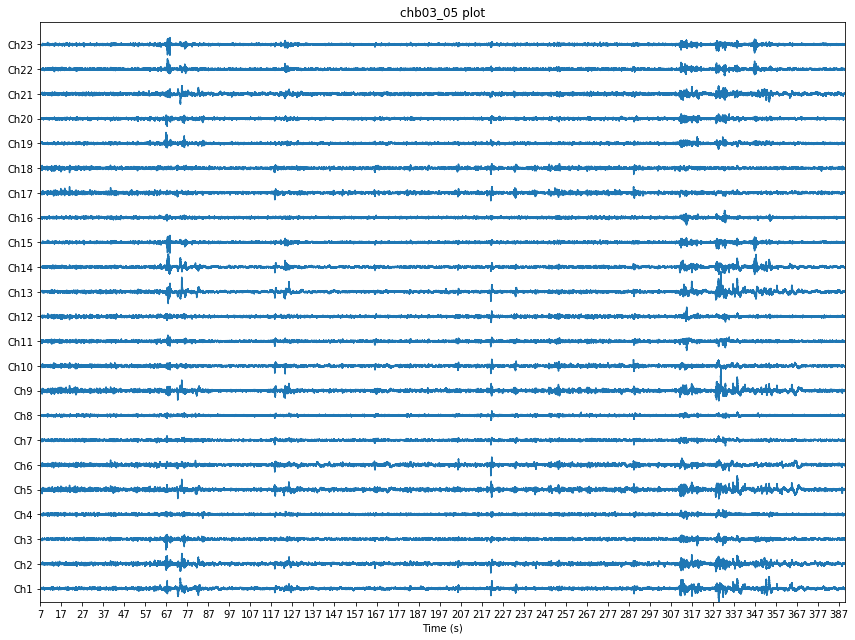

In [3]:
subject[4].plot(2000,100000)

In [4]:
subject.info()

   -Seizure 1: chb03_01 (92672, 105984)
   -Seizure 2: chb03_02 (187136, 203776)
   -Seizure 3: chb03_03 (110592, 128256)
   -Seizure 4: chb03_04 (553472, 566784)
   -Seizure 5: chb03_34 (507392, 519424)
   -Seizure 6: chb03_35 (663552, 679936)
   -Seizure 7: chb03_36 (441600, 455168)
Subject: chb03
 Number of files:    38
 Number of seizures: 7
 Total seizure duration: 402 s (0.293847%)


In [ ]:
chb1 = chb.load_meta('chb01')
chb1 = chb.load_data(chb1,exthd=False)

In [ ]:
subj = chbmit.CHBsubj()

In [ ]:
subj.load_meta('chb01')
subj.load_data()

In [ ]:
num = 0
for eeg in chb1:
    num += eeg.get_num()
print('CHBsubject: Length: %d, Number of seizures: %d' % (len(subj), subj.szr_num))
print('List:       Length: %d, Number of seizures: %d' % (len(chb1), num))

In [ ]:
chb1[2].plot(2000,10000)

In [ ]:
subj.get_file('chb01_03').plot(2000,10000)

## Making epochs

In [ ]:
start = time.clock()
label, epoch = chb.label_epochs(chb1)
stop = time.clock()
print('%f seconds' % (stop-start))